## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This work is copyright DeepSig Inc. 2017.
It is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/

Use of this work, or derivitives inspired by this work is permitted for non-commercial usage only and with explicit citaiton of this original work.

A more detailed description of this work can be found at
https://arxiv.org/abs/1602.04105

A more detailed description of the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Citation of this work is required in derivative works:

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

The RML2016.10a dataset is used for this work (https://radioml.com/datasets/)


In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
# os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
os.environ["THEANO_FLAGS"]  = "device=cpu"
# os.environ["CUDA_VISIBLE_DEVICES"] = " "
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution1D,Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
# import seaborn as sns
import cPickle
import random, sys, keras
import time 

Using Theano backend.


# Dataset setup

In [2]:

# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.10a_dict.pkl",'rb'))
# with open("RML2016.10a_dict.pkl",'rb') as f:
#     Xd = cPickle.load(f, encoding="latin1")

X = cPickle.load(open("pca_D_42.pkl", "rb"))
 
# print(Xd.shape) #Xd is a dictionary
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

# X = []  
lbl = []
for snr in snrs:
    for mod in mods:
#         X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
print(np.shape(X))
print(X)

# print(X.shape)
# print(X)

(20, 11000, 42)
[array([[-0.69712686,  0.01805321,  0.80496473, ...,  0.70526656,
         0.39309808,  0.57733862],
       [-0.56721778, -0.11531144, -0.18005297, ...,  0.48894253,
         0.78696628, -0.21828696],
       [-0.73209857, -0.47467108,  1.49083493, ..., -2.7910853 ,
         0.4139759 , -1.3254276 ],
       ...,
       [-2.39359041, -1.641135  , -0.22455377, ..., -0.96632165,
        -0.66863468,  1.17957479],
       [-1.98937786,  1.06941455,  0.6357025 , ..., -0.00334914,
         1.41691643, -1.00195846],
       [-0.52358686, -2.29096256, -1.10323615, ..., -0.14361898,
        -0.62523117, -0.94214372]]), array([[-0.80049711, -1.91885353,  0.29481734, ...,  0.03166565,
         0.41167632,  0.08340628],
       [-0.28127851,  1.55271357, -1.39868379, ..., -0.58585567,
        -0.22202102,  0.92687191],
       [ 1.72581629,  0.20689234,  0.76681947, ...,  0.27121622,
         1.3578669 ,  0.01898262],
       ...,
       [ 0.14081934, -1.88976068, -0.66238428, ..., -0.69

In [3]:
X = np.vstack(X)
np.shape(X)

(220000, 42)

In [4]:
np.shape(lbl)

(220000, 2)

In [5]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0] ##220000个examples
n_train = n_examples * 0.5 ##一半用来training
# n_train_int = int(n_examples * 0.5)

train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False) ## idx 随机抽取example作为training set，打乱顺序
test_idx = list(set(range(0,n_examples))-set(train_idx)) ## 剩下的idx对应的数据为test set

X_train = X[train_idx]
X_test =  X[test_idx]


# label the data with correponding mod by one_hot technique
def to_onehot(yy):
    # yy_l = list(yy)  ## map() in python 3 has has no attribute of len.
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))
# print(Y_train)(
# print(Y_train.shape) # (110000,11)

In [6]:
X_train

array([[ 4.82292019,  1.82999777,  2.40451896, ...,  0.11466691,
         0.50567164,  0.75840298],
       [-0.50348429, -0.17262818,  0.2261851 , ..., -1.35794706,
         1.51868914,  0.33444529],
       [ 1.54701472,  0.64186856, -1.94924641, ..., -0.31990219,
        -1.21803212,  1.13447077],
       ...,
       [ 2.75727021,  0.20217769,  0.65867134, ..., -0.12082464,
         0.89397862, -0.94769791],
       [ 0.03115709, -0.12992227,  1.08948728, ..., -0.77184472,
        -1.08214586, -0.94227806],
       [-1.17359447,  0.85986096, -4.67227326, ...,  0.96893609,
         1.4138684 , -1.82874242]])

In [7]:
np.shape(X_train)

(110000, 42)

In [8]:
## X.train contains the dataset to be used during training, in_sp represents the data format 
in_shp = list(X_train.shape[1:])
# in_shp = [1,256]
print X_train.shape, in_shp
classes = mods
print classes

print [1]+in_shp


(110000, 42) [42]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
[1, 42]


# Build the NN Model

In [10]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,26] to [N,1,26] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

batch_size = 10
dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp+[1], input_shape=in_shp))
# model.add(Convolution1D(128, 3, init='glorot_uniform',border_mode='same',input_shape = (2,128)))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(42, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 1, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(42, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


/Users/xuyangwang/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(42, (1, 3), kernel_initializer="glorot_uniform", name="conv1", activation="relu", padding="valid")`
  
/Users/xuyangwang/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (1, 3), kernel_initializer="glorot_uniform", name="conv2", activation="relu", padding="valid")`
/Users/xuyangwang/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(42, kernel_initializer="he_normal", activation="relu", name="dense1")`
/Users/xuyangwang/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, kernel_initializer="he_normal", name="dense2")`


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1, 42, 1)          0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 1, 46, 1)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 44, 42)         168       
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 44, 42)         0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 1, 48, 42)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 46, 80)         10160     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 46, 80)        

In [11]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
#     show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

/Users/xuyangwang/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 110000 samples, validate on 110000 samples
Epoch 1/100
 - 41s - loss: 2.1028 - val_loss: 1.8992
Epoch 2/100
 - 41s - loss: 1.9215 - val_loss: 1.8073
Epoch 3/100
 - 40s - loss: 1.8577 - val_loss: 1.7680
Epoch 4/100
 - 41s - loss: 1.8288 - val_loss: 1.7464
Epoch 5/100
 - 41s - loss: 1.8150 - val_loss: 1.7356
Epoch 6/100
 - 41s - loss: 1.8058 - val_loss: 1.7303
Epoch 7/100
 - 41s - loss: 1.7948 - val_loss: 1.7280
Epoch 8/100
 - 42s - loss: 1.7925 - val_loss: 1.7231
Epoch 9/100
 - 42s - loss: 1.7827 - val_loss: 1.7197
Epoch 10/100
 - 42s - loss: 1.7777 - val_loss: 1.7193
Epoch 11/100
 - 42s - loss: 1.7748 - val_loss: 1.7004
Epoch 12/100
 - 43s - loss: 1.7686 - val_loss: 1.6976
Epoch 13/100
 - 43s - loss: 1.7648 - val_loss: 1.6951
Epoch 14/100
 - 42s - loss: 1.7636 - val_loss: 1.6974
Epoch 15/100
 - 43s - loss: 1.7581 - val_loss: 1.6940
Epoch 16/100
 - 43s - loss: 1.7573 - val_loss: 1.6880
Epoch 17/100
 - 43s - loss: 1.7528 - val_loss: 1.6853
Epoch 18/100
 - 43s - loss: 1.7527 - va

# Evaluate and Plot Model Performance

In [13]:
# start_time = time.time()
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
# score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0, batch_size=batch_size)
# end_time = time.time()
# score_time = end_time - start_time
# print score_time
# print score

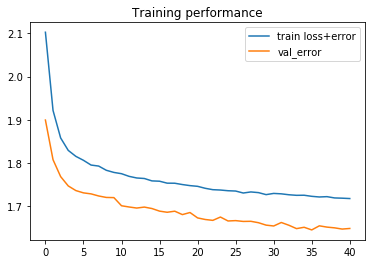

In [14]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [15]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

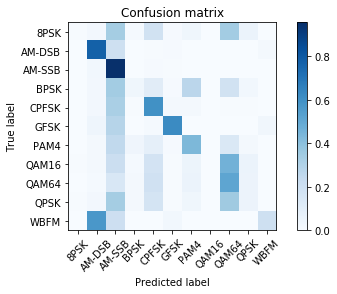

In [16]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Overall Accuracy:  0.09425785482123511
Overall Accuracy:  0.09996391194514616
Overall Accuracy:  0.10622710622710622
Overall Accuracy:  0.11831920383339477
Overall Accuracy:  0.12559328221978824
Overall Accuracy:  0.16564306358381503
Overall Accuracy:  0.24299578831715804
Overall Accuracy:  0.37670609645131936
Overall Accuracy:  0.5148787656135194
Overall Accuracy:  0.5463096960926194
Overall Accuracy:  0.5194899817850638
Overall Accuracy:  0.5321467490010897
Overall Accuracy:  0.5244920174165457
Overall Accuracy:  0.521055485270197
Overall Accuracy:  0.5254706533776301
Overall Accuracy:  0.5250181290790428
Overall Accuracy:  0.5172981878088962
Overall Accuracy:  0.5251396648044693
Overall Accuracy:  0.5099543378995434
Overall Accuracy:  0.5291296625222025


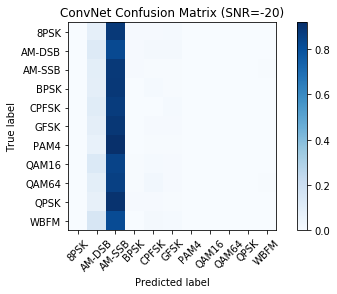

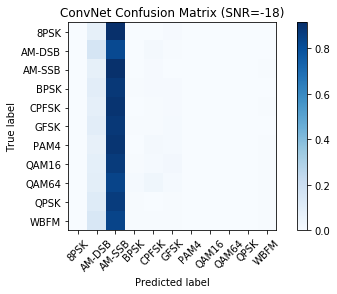

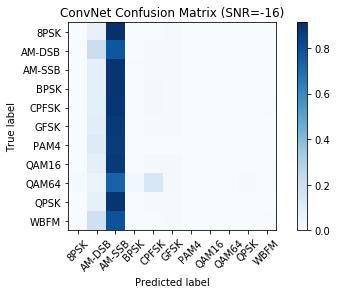

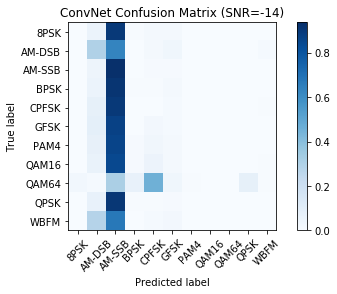

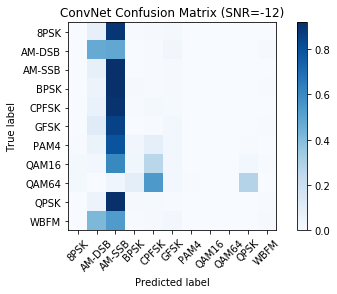

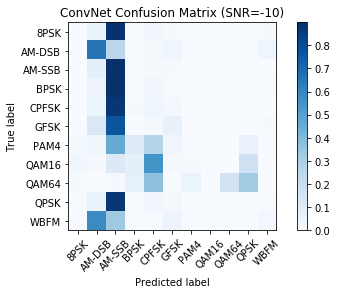

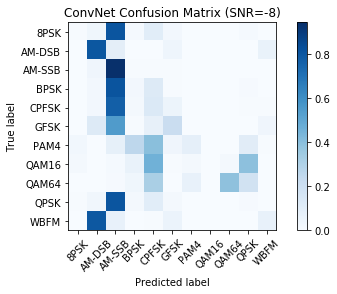

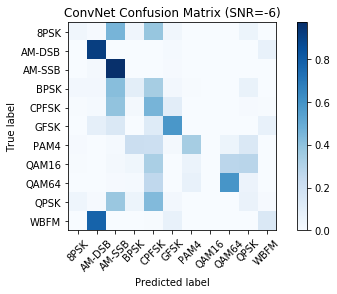

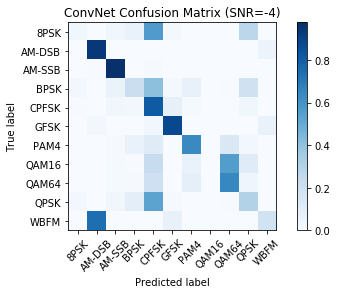

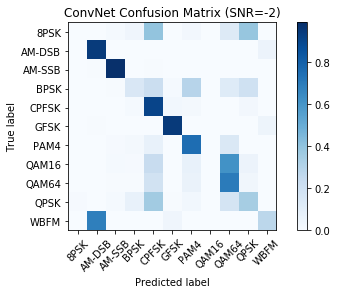

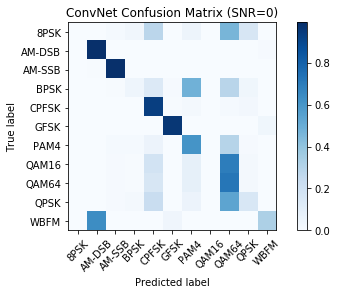

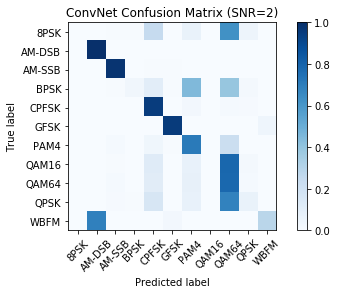

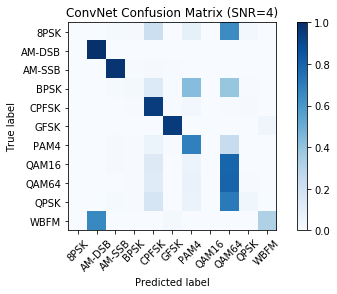

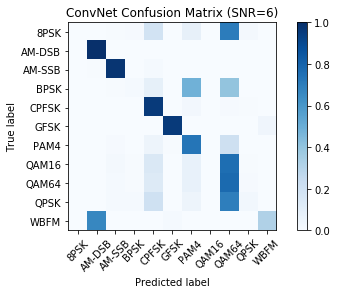

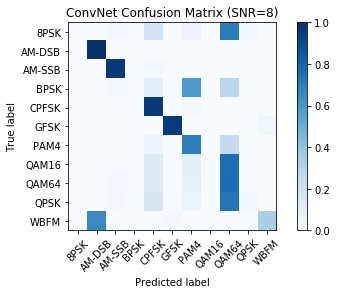

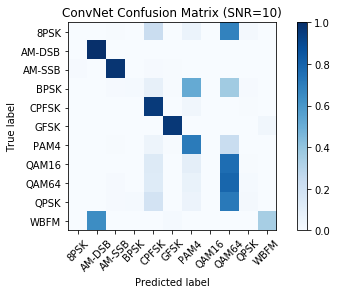

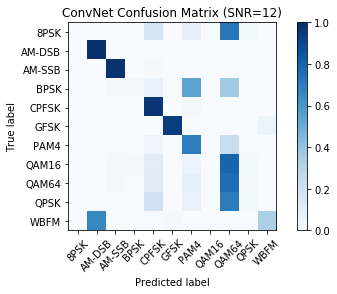

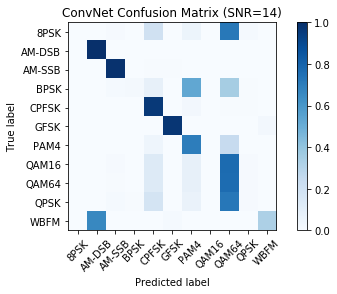

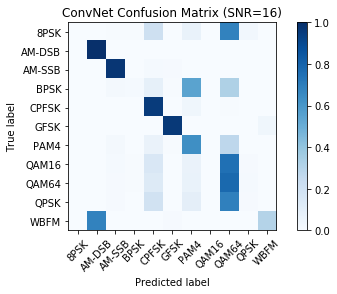

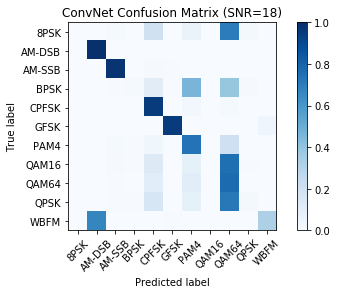

In [17]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [18]:
# Save results to a pickle file for plotting later
print acc
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.5194899817850638, 16: 0.5099543378995434, 2: 0.5321467490010897, 4: 0.5244920174165457, 6: 0.521055485270197, 8: 0.5254706533776301, 12: 0.5172981878088962, 10: 0.5250181290790428, -20: 0.09425785482123511, 18: 0.5291296625222025, -18: 0.09996391194514616, -16: 0.10622710622710622, -14: 0.11831920383339477, -12: 0.12559328221978824, 14: 0.5251396648044693, -10: 0.16564306358381503, -8: 0.24299578831715804, -6: 0.37670609645131936, -4: 0.5148787656135194, -2: 0.5463096960926194}


Text(0.5,1,'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

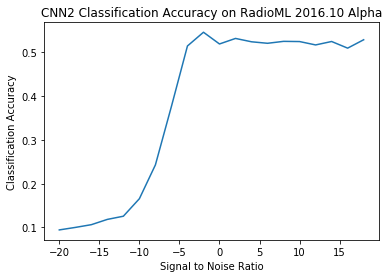

In [19]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")